In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import dill
from IPython.core import display as ICD  # to print multiple nice pandas tables
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tqdm
from tqdm import tqdm_notebook, tnrange
sns.set()

In [2]:
import datasets
import classify
from simple_model import SimpleModel
from testing import test_simple_model

In [3]:
from collections import defaultdict
results = defaultdict(dict)
dump = defaultdict(dict)

In [6]:
def gradient_w(model, dataset, alpha=0.01, epochs=150):
    train_scores = []
    valid_scores = []
    test_scores = []
    model.fit(dataset.train_samples(), dataset.train_labels())
    if epochs is None:
        t = tnrange(100000)
    else:
        t = tnrange(epochs)
    for e in t:
        w = model.get_matrix_w()
        w -= alpha * model.dw(dataset.train_samples(), dataset.train_labels())
        model.save_matrix_w(w)
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_score = model.score(dataset.train_samples(), dataset.train_labels())
        valid_score = model.score(dataset.valid_samples(), dataset.valid_labels())
        test_score = model.score(dataset.test_samples(), dataset.test_labels())
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        test_scores.append(test_score)
        t.set_postfix(train_score=train_score, valid_score=valid_score, test_score=test_score)
        if epochs is None and e > 30:
            end_mean = np.mean(valid_scores[-10:])
            previos_mean = np.mean(valid_scores[-20:-10])
            t.set_postfix(train_score=train_score, valid_score=valid_score, test_score=test_score, previos=previos_mean, end=end_mean)
            if end_mean < previos_mean:
                break
    plt.plot(train_scores)
    plt.plot(valid_scores)
    plt.plot(test_scores)
    plt.legend(['train', 'valid', 'test'])
    plt.show()
    return train_scores, valid_scores, test_scores

In [7]:
def test_simple_model_with_gradient(model, dataset, gradient_iters=300, dims=300, alpha=0.01, tag=None, results=None, dump=None, with_models=False):
    train_ps, valid_ps, test_ps = gradient_w(model, dataset, alpha, gradient_iters)
    #train_p = model.score(dataset.train_samples(), dataset.train_labels())
    #test_p = model.score(dataset.test_samples(), dataset.test_labels())
    
    train_p = np.mean(train_ps[-10:])
    valid_p = np.mean(valid_ps[-10:])
    test_p = np.mean(test_ps[-10:])
    if results is not None:
        results[dataset.name()][('batch', tag, alpha, dims, 'train')] = train_p
        results[dataset.name()][('batch', tag, alpha, dims, 'valid')] = valid_p
        results[dataset.name()][('batch', tag, alpha, dims, 'test')] = test_p
        
    if dump is not None:
        dump[dataset.name()][('batch', tag, alpha)] = {
            'train': list(train_ps),
            'valid': list(valid_ps),
            'test': list(test_ps),
            'w': model.internal_w,
        }
        if with_models:
            dump[dataset.name()][('batch', tag, alpha)]['model']= model
            
        
    #raw_results[dataset.name()][('gradientw', tag, alpha)] = (train_ps, test_ps)
    print(dataset.name())
    print("Train precision", train_p)
    print("Valid precision", valid_p)
    print("Test precision", test_p)

CRDataset None 0.1 200 CRDataset_None_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

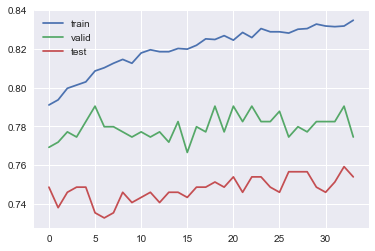

CRDataset
Train precision 0.8308940397350992
Valid precision 0.7814323607427056
Test precision 0.7523809523809524
[('aux', 0.9965387670284408), ('handheld', 1.0057538652783018), ('booted', 1.0000229156794977), ('shipping', 0.9449250353980186), ('words', 0.9877278971391188), ('accessible', 1.0005574475856265), ('faster', 1.021180872702035), ('suggested', 1.000103154454103), ('04', 1.0000133759728023), ('database', 1.0100543998063347)]
CRDataset None 0.1 300 CRDataset_None_0.1_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



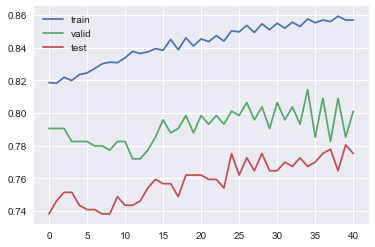

CRDataset
Train precision 0.8559602649006622
Valid precision 0.7978779840848806
Test precision 0.771957671957672
[('aux', 0.9855410905057617), ('handheld', 1.0022846098134832), ('booted', 1.000226231944689), ('shipping', 1.0536056770238376), ('words', 0.953146399358254), ('accessible', 1.0012740156583824), ('faster', 1.0113650935369491), ('suggested', 1.0000694882112167), ('04', 0.9989096524490504), ('database', 1.0234295725472053)]
CRDataset None 0.1 400 CRDataset_None_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

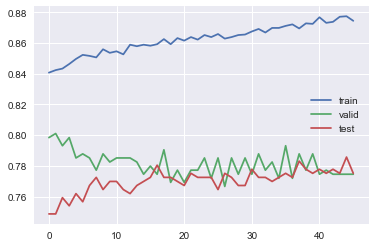

CRDataset
Train precision 0.8740066225165564
Valid precision 0.7774535809018568
Test precision 0.7775132275132275
[('aux', 0.9758565449833327), ('handheld', 1.0011607831702531), ('booted', 1.0020781539421664), ('shipping', 1.0614264687677362), ('words', 0.9382422459810893), ('accessible', 0.9990983549825647), ('faster', 1.039966073366209), ('suggested', 1.0001085283839177), ('04', 0.9999948463883656), ('database', 0.993676168434504)]
CRDataset None 0.01 200 CRDataset_None_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



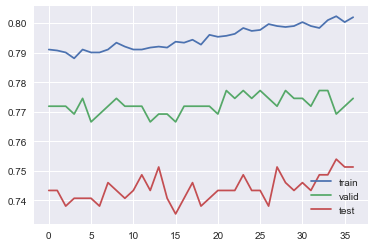


CRDataset
Train precision 0.8
Valid precision 0.7740053050397877
Test precision 0.7484126984126984
[('aux', 0.9996087045557219), ('handheld', 1.0006362905984525), ('booted', 1.0001325134730665), ('shipping', 0.9943169357204537), ('words', 0.999822530162292), ('accessible', 1.000215562287624), ('faster', 1.0020110158688886), ('suggested', 1.0000043677883574), ('04', 1.000003254265788), ('database', 0.9997869038477879)]
CRDataset None 0.01 300 CRDataset_None_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

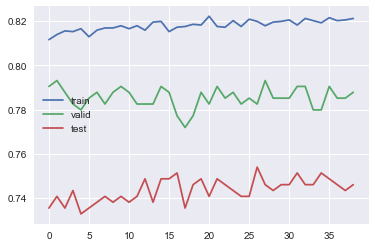

CRDataset
Train precision 0.8202649006622517
Valid precision 0.7859416445623342
Test precision 0.7470899470899471
[('aux', 0.9985605287202397), ('handheld', 1.0001216321244895), ('booted', 1.000101042648413), ('shipping', 1.0055265549392396), ('words', 0.9930097167413626), ('accessible', 1.0003125540907796), ('faster', 1.000304259216124), ('suggested', 1.0000062654003727), ('04', 0.9999917691094488), ('database', 1.0012997637722658)]
CRDataset None 0.01 400 CRDataset_None_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



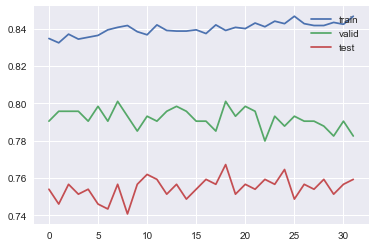


CRDataset
Train precision 0.8433112582781457
Valid precision 0.7877984084880637
Test precision 0.7566137566137566
[('aux', 0.9980731019590261), ('handheld', 1.0000303223379803), ('booted', 0.999793250361364), ('shipping', 1.0062927874037402), ('words', 0.9945964138112714), ('accessible', 0.9999762660062619), ('faster', 1.0016565100968184), ('suggested', 1.0000046029122487), ('04', 0.9999873552595272), ('database', 0.9986138527534824)]
CRDataset None 0.001 200 CRDataset_None_0.001_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

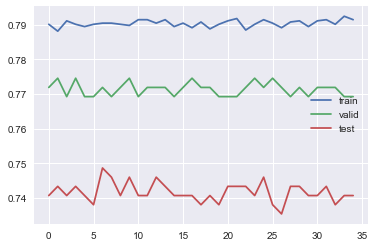

CRDataset
Train precision 0.7906953642384106
Valid precision 0.7710875331564987
Test precision 0.7404761904761904
[('aux', 0.9999870995805628), ('handheld', 1.000064840035169), ('booted', 1.000001319950406), ('shipping', 0.9994126457151522), ('words', 1.0000192726267623), ('accessible', 1.0000315664693393), ('faster', 1.000188077399459), ('suggested', 1.000000413979167), ('04', 1.0000004163635363), ('database', 0.9999769649668199)]
CRDataset None 0.001 300 CRDataset_None_0.001_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



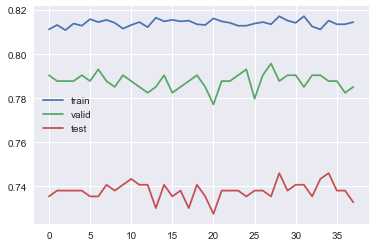


CRDataset
Train precision 0.8144701986754967
Valid precision 0.7877984084880636
Test precision 0.7399470899470899
[('aux', 0.9998837835251505), ('handheld', 1.0000149687049318), ('booted', 1.0000047160794978), ('shipping', 1.0005580638078846), ('words', 0.9994117825760169), ('accessible', 1.0000362144380825), ('faster', 1.0000190579623163), ('suggested', 1.0000006902277552), ('04', 0.9999985543261732), ('database', 1.000153497778945)]
CRDataset None 0.001 400 CRDataset_None_0.001_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

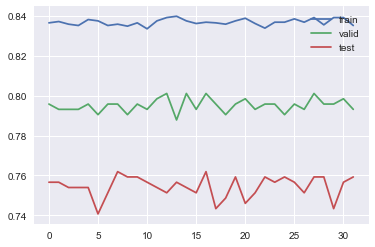

CRDataset
Train precision 0.8370198675496688
Valid precision 0.7954907161803714
Test precision 0.7560846560846561
[('aux', 0.9998290854662826), ('handheld', 1.0000028248641546), ('booted', 0.9999615652913881), ('shipping', 1.0006447694928742), ('words', 0.9994806930859973), ('accessible', 0.9999935103103016), ('faster', 1.00014685581127), ('suggested', 1.000000470220026), ('04', 0.9999958838128262), ('database', 0.999843358426095)]
CRDataset tfidf 0.1 200 CRDataset_tfidf_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



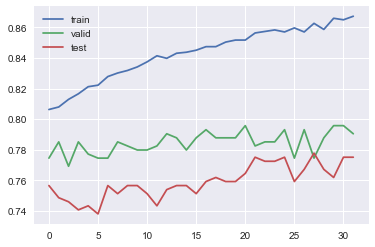


CRDataset
Train precision 0.8608278145695365
Valid precision 0.7875331564986737
Test precision 0.7703703703703704
[('aux', 0.9953906091746518), ('handheld', 1.0015814503470444), ('booted', 0.997492082990578), ('shipping', 1.0258699786094776), ('words', 0.9962023502103919), ('accessible', 1.0026367127757005), ('faster', 1.0351714668183207), ('suggested', 1.0001708719822489), ('04', 1.0000681425378386), ('database', 1.0468310364924773)]
CRDataset tfidf 0.1 300 CRDataset_tfidf_0.1_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

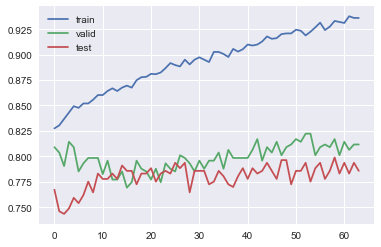

CRDataset
Train precision 0.9316225165562916
Valid precision 0.8092838196286471
Test precision 0.7883597883597883
[('aux', 0.9395453253519767), ('handheld', 1.0000014998660045), ('booted', 0.9651999418682705), ('shipping', 1.0023256373668583), ('words', 0.896285393798419), ('accessible', 0.9900620487368971), ('faster', 1.0440961991411903), ('suggested', 1.000060099340538), ('04', 0.9996889965470722), ('database', 1.0115411872247042)]
CRDataset tfidf 0.1 400 CRDataset_tfidf_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



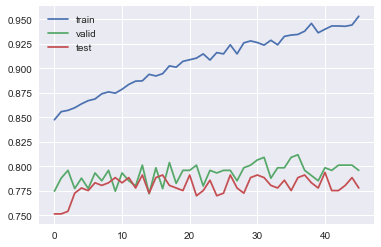


CRDataset
Train precision 0.9419536423841061
Valid precision 0.7976127320954907
Test precision 0.783068783068783
[('aux', 0.9688806406164633), ('handheld', 1.0000000084344578), ('booted', 0.9772407732301852), ('shipping', 1.0191640096273624), ('words', 0.9284731677238005), ('accessible', 0.981101368471452), ('faster', 0.9940526339504868), ('suggested', 1.0000074847779783), ('04', 1.0002132950191263), ('database', 0.9301067233557229)]
CRDataset tfidf 0.01 200 CRDataset_tfidf_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

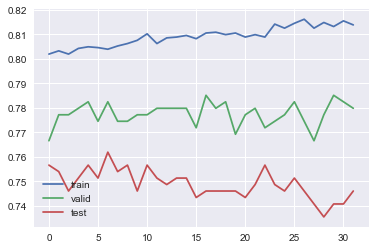

CRDataset
Train precision 0.8136754966887418
Valid precision 0.7771883289124668
Test precision 0.7452380952380951
[('aux', 0.9992269450616943), ('handheld', 1.000658733464409), ('booted', 0.9998730341401139), ('shipping', 0.9935926247231766), ('words', 0.9980852402904113), ('accessible', 1.0004739903007065), ('faster', 1.0034311953937725), ('suggested', 1.0000023273543788), ('04', 1.000005664967541), ('database', 1.0013980842234147)]
CRDataset tfidf 0.01 300 CRDataset_tfidf_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



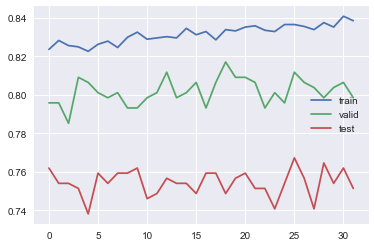


CRDataset
Train precision 0.8359933774834436
Valid precision 0.8018567639257295
Test precision 0.7542328042328043
[('aux', 0.9952539543050465), ('handheld', 1.0000008966210074), ('booted', 0.9987989496818659), ('shipping', 1.0075498992140668), ('words', 0.9868331331249924), ('accessible', 1.0004939649940656), ('faster', 1.001555387955933), ('suggested', 1.0000032047973346), ('04', 0.9997967813312286), ('database', 0.9987475858886711)]
CRDataset tfidf 0.01 400 CRDataset_tfidf_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

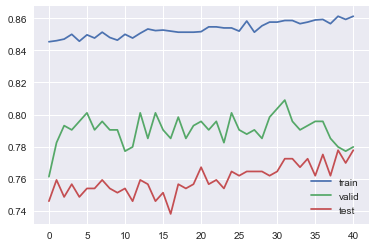

CRDataset
Train precision 0.8588079470198677
Valid precision 0.790185676392573
Test precision 0.7708994708994709
[('aux', 0.9958235174987294), ('handheld', 1.0000000011100154), ('booted', 0.998905718213933), ('shipping', 1.0048518141018188), ('words', 0.9788167636144872), ('accessible', 1.0001445406535745), ('faster', 1.0022329076021743), ('suggested', 1.0000059445226517), ('04', 1.0000166261357646), ('database', 0.9913057733890387)]
CRDataset tfidf 0.001 200 CRDataset_tfidf_0.001_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



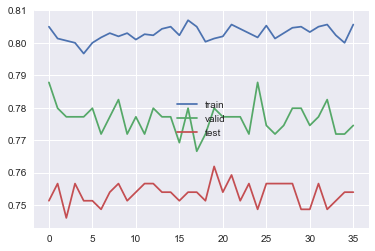


CRDataset
Train precision 0.8035761589403974
Valid precision 0.7758620689655172
Test precision 0.7531746031746032
[('aux', 0.9999105125521554), ('handheld', 1.0000753044623025), ('booted', 0.9999829142818758), ('shipping', 0.9995347493204308), ('words', 0.9997998865631993), ('accessible', 1.0000605379053769), ('faster', 1.0003685779972926), ('suggested', 1.000000129873053), ('04', 1.0000004895423578), ('database', 1.0001037893834321)]
CRDataset tfidf 0.001 300 CRDataset_tfidf_0.001_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

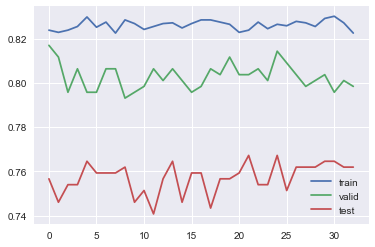

CRDataset
Train precision 0.8266225165562913
Valid precision 0.8026525198938991
Test precision 0.7611111111111111
[('aux', 0.9996125043402981), ('handheld', 1.0000001896454647), ('booted', 0.999925208988212), ('shipping', 1.0009542676295444), ('words', 0.9989662812435633), ('accessible', 1.000057805905874), ('faster', 1.0001678881520473), ('suggested', 1.0000003357135456), ('04', 0.9999640425865011), ('database', 0.9999720687645424)]
CRDataset tfidf 0.001 400 CRDataset_tfidf_0.001_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-14:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



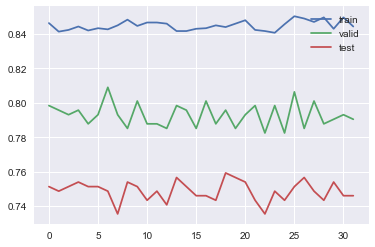


CRDataset
Train precision 0.8461258278145696
Valid precision 0.7917771883289125
Test precision 0.7473544973544973
[('aux', 0.9997215340963906), ('handheld', 1.0000000004055873), ('booted', 0.9998953100401721), ('shipping', 1.0003861820884166), ('words', 0.9983204739627992), ('accessible', 1.0000182106968387), ('faster', 1.0001138504074782), ('suggested', 1.0000006166720818), ('04', 1.0000008751592866), ('database', 0.9993783063856426)]
CRDataset tfchi2 0.1 200 CRDataset_tfchi2_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

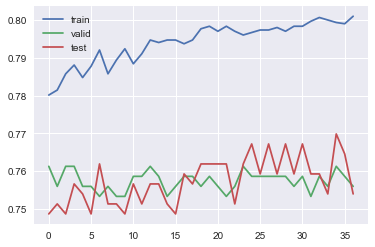

CRDataset
Train precision 0.7991390728476822
Valid precision 0.7575596816976127
Test precision 0.7613756613756613
[('aux', 0.999999999973252), ('handheld', 0.9999999271834675), ('booted', 0.9999999662463321), ('shipping', 1.0000123415362348), ('words', 0.999998821495957), ('accessible', 1.0000002998281843), ('faster', 1.0002111896128671), ('suggested', 1.000006723658528), ('04', 1.0000000677865568), ('database', 1.0005828061727633)]
CRDataset tfchi2 0.1 300 CRDataset_tfchi2_0.1_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



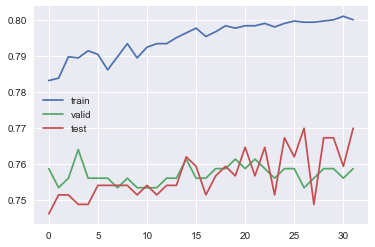


CRDataset
Train precision 0.7995033112582781
Valid precision 0.7572944297082229
Test precision 0.7626984126984128
[('aux', 1.0000000005467515), ('handheld', 0.999999909046133), ('booted', 1.0000000607120785), ('shipping', 0.9999790117514639), ('words', 0.9999995476532578), ('accessible', 1.0000002004251294), ('faster', 0.9999949662110114), ('suggested', 1.0000125630107646), ('04', 0.9999999023261942), ('database', 1.0026464015723913)]
CRDataset tfchi2 0.1 400 CRDataset_tfchi2_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

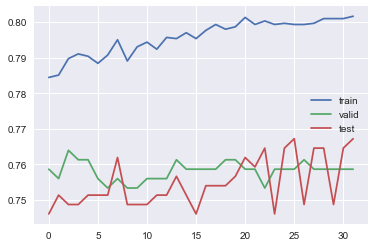

CRDataset
Train precision 0.8002317880794703
Valid precision 0.7583554376657825
Test precision 0.76005291005291
[('aux', 1.0000000007797925), ('handheld', 1.0000021374824932), ('booted', 0.9999999917619632), ('shipping', 0.9999835732597555), ('words', 0.9999995453551032), ('accessible', 1.0000000277748418), ('faster', 0.99979054202418), ('suggested', 1.00001822263638), ('04', 0.9999999313938746), ('database', 1.0101586166265573)]
CRDataset tfchi2 0.01 200 CRDataset_tfchi2_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



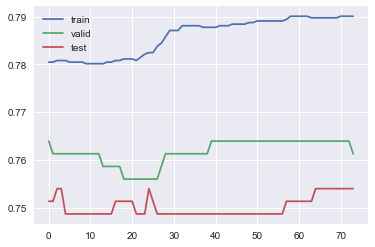


CRDataset
Train precision 0.7898675496688742
Valid precision 0.7636604774535809
Test precision 0.753968253968254
[('aux', 0.9999999999686414), ('handheld', 1.000000058154347), ('booted', 1.000000013699903), ('shipping', 1.0000053095365529), ('words', 1.0000000099095963), ('accessible', 1.000000058620715), ('faster', 1.0000552296570706), ('suggested', 1.000001498858759), ('04', 1.0000000192472076), ('database', 1.0001672998670652)]
CRDataset tfchi2 0.01 300 CRDataset_tfchi2_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

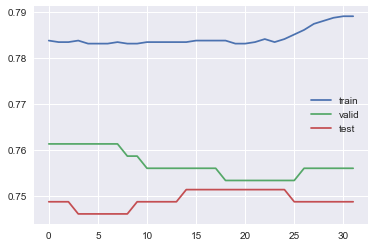

CRDataset
Train precision 0.786523178807947
Valid precision 0.7549071618037134
Test precision 0.7494708994708994
[('aux', 1.0000000000267864), ('handheld', 1.0000000487186476), ('booted', 1.000000019661706), ('shipping', 0.999998866325468), ('words', 1.0000000983291695), ('accessible', 1.0000000177843753), ('faster', 1.0000042706517462), ('suggested', 1.0000012701551733), ('04', 0.999999992572253), ('database', 1.0003039306686472)]
CRDataset tfchi2 0.01 400 CRDataset_tfchi2_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-17:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



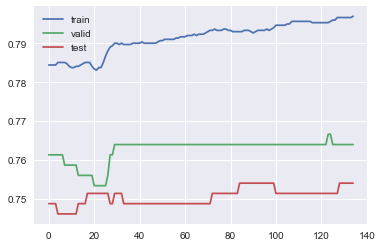


CRDataset
Train precision 0.79658940397351
Valid precision 0.7639257294429708
Test precision 0.7531746031746032
[('aux', 1.000000000295975), ('handheld', 1.0000009668627656), ('booted', 1.0000000164271938), ('shipping', 0.9999947712541343), ('words', 0.9999999439107861), ('accessible', 0.9999999984088129), ('faster', 0.9999101103793447), ('suggested', 1.0000079089284208), ('04', 0.9999999731442156), ('database', 1.0044641807600678)]
CRDataset tfchi2 0.001 200 CRDataset_tfchi2_0.001_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

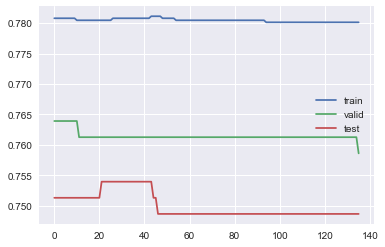

CRDataset
Train precision 0.7801324503311257
Valid precision 0.7610079575596818
Test precision 0.7486772486772486
[('aux', 0.9999999999889502), ('handheld', 1.0000000203873263), ('booted', 1.000000006741487), ('shipping', 1.0000011199988923), ('words', 1.000000062617737), ('accessible', 1.0000000086282146), ('faster', 1.0000110666726119), ('suggested', 1.0000002708202393), ('04', 1.0000000050253586), ('database', 1.000030537108999)]
CRDataset tfchi2 0.001 300 CRDataset_tfchi2_0.001_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-18:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



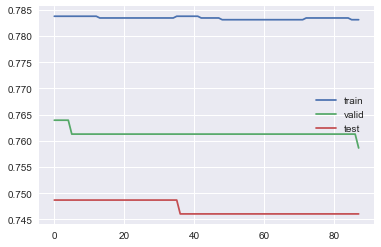


CRDataset
Train precision 0.7833443708609271
Valid precision 0.7610079575596818
Test precision 0.746031746031746
[('aux', 1.0000000000054607), ('handheld', 1.0000000169523477), ('booted', 1.000000006444917), ('shipping', 0.9999997222888198), ('words', 1.0000000384754502), ('accessible', 1.0000000044005921), ('faster', 1.0000013880035985), ('suggested', 1.0000003450876003), ('04', 0.9999999982019878), ('database', 1.00008358163615)]
CRDataset tfchi2 0.001 400 CRDataset_tfchi2_0.001_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

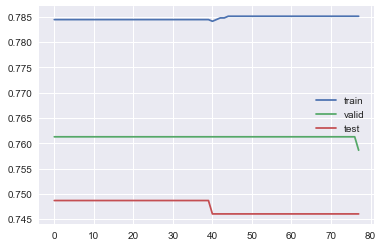

CRDataset
Train precision 0.7850993377483444
Valid precision 0.7610079575596818
Test precision 0.746031746031746
[('aux', 1.0000000000099425), ('handheld', 1.0000000650449277), ('booted', 1.000000004554522), ('shipping', 0.9999997943606052), ('words', 1.0000000333024), ('accessible', 0.999999998040223), ('faster', 0.9999947038678628), ('suggested', 1.0000004457455611), ('04', 0.9999999993215141), ('database', 1.000259021511761)]
CRDataset tfig 0.1 200 CRDataset_tfig_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



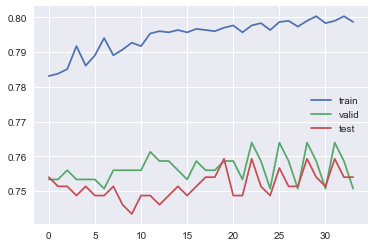


CRDataset
Train precision 0.7987086092715232
Valid precision 0.7570291777188329
Test precision 0.753968253968254
[('aux', 0.9999999999593251), ('handheld', 1.0000003623282046), ('booted', 1.0000000559089999), ('shipping', 1.0000007004698521), ('words', 0.9999980343304739), ('accessible', 1.000000277892952), ('faster', 1.0001553460271944), ('suggested', 1.0000045570102583), ('04', 1.000000060885563), ('database', 1.0007145895934375)]
CRDataset tfig 0.1 300 CRDataset_tfig_0.1_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

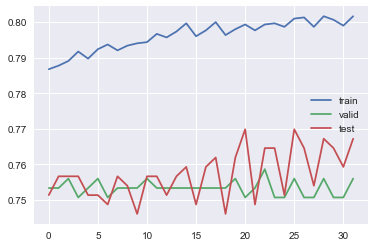

CRDataset
Train precision 0.8001655629139073
Valid precision 0.7530503978779841
Test precision 0.7626984126984129
[('aux', 1.0000000006219603), ('handheld', 1.0000008098055977), ('booted', 1.0000001246790435), ('shipping', 0.9999755602752871), ('words', 0.9999986015036206), ('accessible', 1.0000002615655832), ('faster', 0.9999558445316347), ('suggested', 1.0000128608066956), ('04', 0.9999999697328054), ('database', 1.0027264299263365)]
CRDataset tfig 0.1 400 CRDataset_tfig_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-20:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



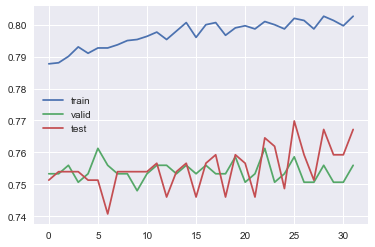


CRDataset
Train precision 0.8007947019867551
Valid precision 0.7538461538461538
Test precision 0.7608465608465609
[('aux', 1.0000000008078966), ('handheld', 1.0000010780512973), ('booted', 0.9999999916687087), ('shipping', 0.9999988455823897), ('words', 0.9999987367850397), ('accessible', 1.000000348320889), ('faster', 0.9997654917518365), ('suggested', 1.0000176725056258), ('04', 0.9999999421181581), ('database', 1.0094446343066283)]
CRDataset tfig 0.01 200 CRDataset_tfig_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

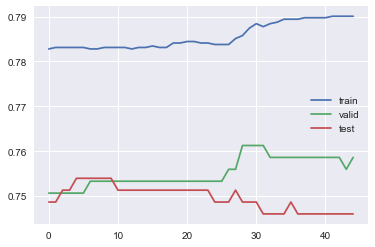

CRDataset
Train precision 0.7898013245033113
Valid precision 0.7583554376657824
Test precision 0.7462962962962962
[('aux', 0.9999999999709096), ('handheld', 1.0000001131647345), ('booted', 1.000000025963994), ('shipping', 1.000001518297863), ('words', 0.9999999116080478), ('accessible', 1.0000000302613687), ('faster', 1.0000304444597712), ('suggested', 1.0000006565122923), ('04', 1.0000000124642823), ('database', 1.0001325208776781)]
CRDataset tfig 0.01 300 CRDataset_tfig_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-21:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



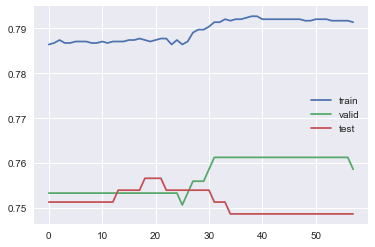


CRDataset
Train precision 0.7917880794701986
Valid precision 0.7610079575596818
Test precision 0.7486772486772486
[('aux', 1.000000000073488), ('handheld', 1.0000002220571202), ('booted', 1.0000000417964179), ('shipping', 0.9999968170379062), ('words', 0.9999998984919226), ('accessible', 1.0000000432474618), ('faster', 0.9999994568564275), ('suggested', 1.0000024012037092), ('04', 0.9999999982151515), ('database', 1.0005403120181529)]
CRDataset tfig 0.01 400 CRDataset_tfig_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

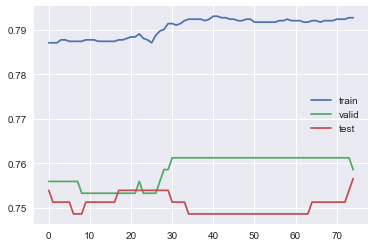

CRDataset
Train precision 0.7922516556291391
Valid precision 0.7610079575596818
Test precision 0.7521164021164022
[('aux', 1.0000000001485758), ('handheld', 1.000000296673341), ('booted', 1.0000000213781386), ('shipping', 1.0000022190383033), ('words', 0.999999842174017), ('accessible', 1.0000000527815227), ('faster', 0.9999480803319052), ('suggested', 1.00000429683554), ('04', 0.9999999889999808), ('database', 1.0023448825375951)]
CRDataset tfig 0.001 200 CRDataset_tfig_0.001_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-22:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



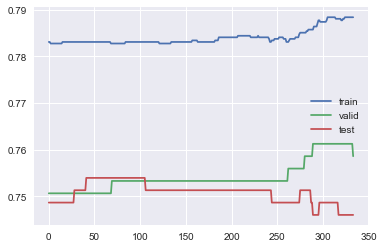


CRDataset
Train precision 0.7884105960264901
Valid precision 0.7610079575596818
Test precision 0.746031746031746
[('aux', 0.9999999999745312), ('handheld', 1.0000000891183964), ('booted', 1.0000000218584038), ('shipping', 1.000001163717419), ('words', 0.9999999621690783), ('accessible', 1.000000020737707), ('faster', 1.0000230737450482), ('suggested', 1.000000481158426), ('04', 1.000000010086227), ('database', 1.0000981450042004)]
CRDataset tfig 0.001 300 CRDataset_tfig_0.001_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

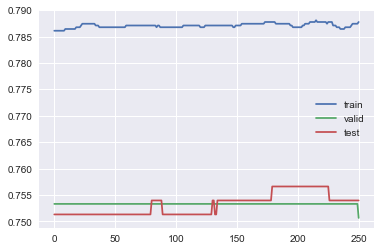

CRDataset
Train precision 0.7872185430463576
Valid precision 0.7530503978779841
Test precision 0.753968253968254
[('aux', 1.0000000000205924), ('handheld', 1.0000001096033924), ('booted', 1.0000000231963804), ('shipping', 0.9999986132073361), ('words', 1.0000000020743494), ('accessible', 1.0000000151565391), ('faster', 1.0000000900347912), ('suggested', 1.0000010187987076), ('04', 1.0000000005611605), ('database', 1.0002307852671333)]
CRDataset tfig 0.001 400 CRDataset_tfig_0.001_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-23:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



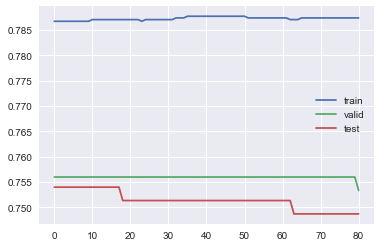


CRDataset
Train precision 0.7874172185430464
Valid precision 0.7557029177718833
Test precision 0.7486772486772486
[('aux', 1.0000000000105582), ('handheld', 1.000000038209526), ('booted', 1.0000000048046456), ('shipping', 1.0000002976328495), ('words', 1.0000000033396794), ('accessible', 1.000000003431032), ('faster', 0.9999943673902929), ('suggested', 1.0000004540192557), ('04', 0.9999999994235201), ('database', 1.0002527659973475)]
CRDataset tfgr 0.1 200 CRDataset_tfgr_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

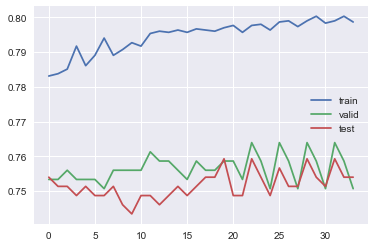

CRDataset
Train precision 0.7987086092715232
Valid precision 0.7570291777188329
Test precision 0.753968253968254
[('aux', 0.999999999959385), ('handheld', 1.000000362226197), ('booted', 1.0000000559064772), ('shipping', 1.0000006986344383), ('words', 0.9999980341861395), ('accessible', 1.0000002779093617), ('faster', 1.0001554042752687), ('suggested', 1.0000045574170962), ('04', 1.0000000608787223), ('database', 1.0007146478452458)]
CRDataset tfgr 0.1 300 CRDataset_tfgr_0.1_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-24:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



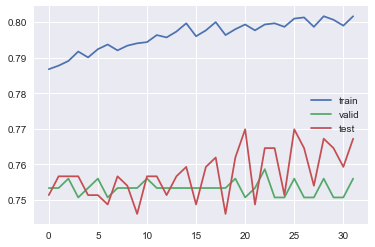


CRDataset
Train precision 0.8001655629139073
Valid precision 0.7530503978779841
Test precision 0.7626984126984129
[('aux', 1.0000000006220435), ('handheld', 1.0000008127109064), ('booted', 1.0000001247580341), ('shipping', 0.9999755265945552), ('words', 0.9999986015065842), ('accessible', 1.0000002610986538), ('faster', 0.9999550910848071), ('suggested', 1.0000128630697254), ('04', 0.9999999696945389), ('database', 1.0027270888616409)]
CRDataset tfgr 0.1 400 CRDataset_tfgr_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

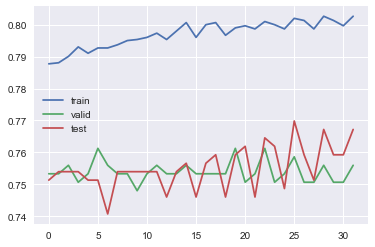

CRDataset
Train precision 0.8007947019867551
Valid precision 0.7538461538461538
Test precision 0.7608465608465609
[('aux', 1.0000000008042513), ('handheld', 1.0000010730227014), ('booted', 0.9999999917147052), ('shipping', 0.9999987953624958), ('words', 0.9999987366927006), ('accessible', 1.0000003498931176), ('faster', 0.9997659189893456), ('suggested', 1.0000176610833182), ('04', 0.9999999421521389), ('database', 1.0094445787292938)]
CRDataset tfgr 0.01 200 CRDataset_tfgr_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-25:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



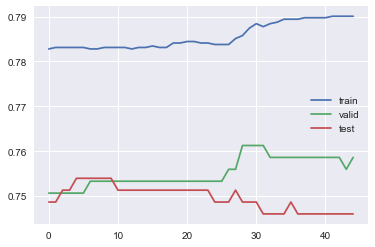


CRDataset
Train precision 0.7898013245033113
Valid precision 0.7583554376657824
Test precision 0.7462962962962962
[('aux', 0.9999999999709109), ('handheld', 1.0000001131533691), ('booted', 1.000000025967379), ('shipping', 1.0000015169942338), ('words', 0.999999911608478), ('accessible', 1.0000000302702619), ('faster', 1.0000304477527027), ('suggested', 1.0000006565280453), ('04', 1.000000012465373), ('database', 1.0001325502399767)]
CRDataset tfgr 0.01 300 CRDataset_tfgr_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

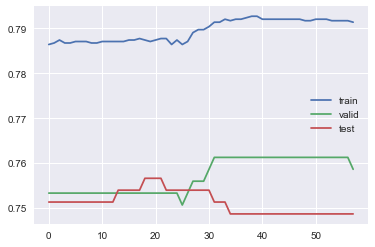

CRDataset
Train precision 0.7917880794701986
Valid precision 0.7610079575596818
Test precision 0.7486772486772486
[('aux', 1.0000000000735236), ('handheld', 1.0000002214540198), ('booted', 1.0000000418051065), ('shipping', 0.9999968120912667), ('words', 0.999999898472118), ('accessible', 1.0000000430861458), ('faster', 0.9999994022740424), ('suggested', 1.00000240140603), ('04', 0.9999999982075076), ('database', 1.0005406651928452)]
CRDataset tfgr 0.01 400 CRDataset_tfgr_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-26:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



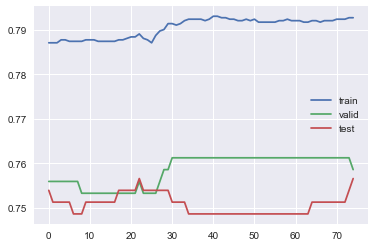


CRDataset
Train precision 0.7922516556291391
Valid precision 0.7610079575596818
Test precision 0.7521164021164022
[('aux', 1.000000000148855), ('handheld', 1.0000002953477516), ('booted', 1.0000000214688394), ('shipping', 1.0000021947113948), ('words', 0.9999998421014153), ('accessible', 1.0000000525207147), ('faster', 0.999948144776077), ('suggested', 1.0000042957157205), ('04', 0.99999998901678), ('database', 1.0023449914151952)]
CRDataset tfgr 0.001 200 CRDataset_tfgr_0.001_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

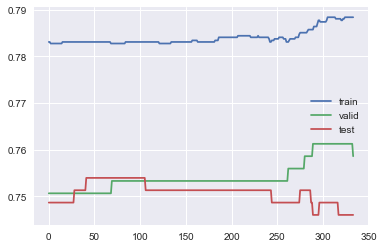

CRDataset
Train precision 0.7884105960264901
Valid precision 0.7610079575596818
Test precision 0.746031746031746
[('aux', 0.9999999999745292), ('handheld', 1.0000000891148333), ('booted', 1.0000000218591294), ('shipping', 1.0000011636005106), ('words', 0.9999999621700643), ('accessible', 1.0000000207346829), ('faster', 1.0000230751079813), ('suggested', 1.0000004811573335), ('04', 1.0000000100863655), ('database', 1.0000981464841743)]
CRDataset tfgr 0.001 300 CRDataset_tfgr_0.001_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-27:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



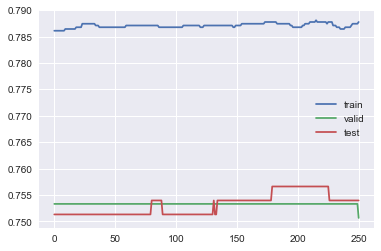


CRDataset
Train precision 0.7872185430463576
Valid precision 0.7530503978779841
Test precision 0.753968253968254
[('aux', 1.0000000000205929), ('handheld', 1.0000001094837352), ('booted', 1.0000000231896258), ('shipping', 0.9999986138604081), ('words', 1.0000000020747024), ('accessible', 1.0000000151553947), ('faster', 1.0000001202362767), ('suggested', 1.000001018565419), ('04', 1.0000000005603782), ('database', 1.000230780134992)]
CRDataset tfgr 0.001 400 CRDataset_tfgr_0.001_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

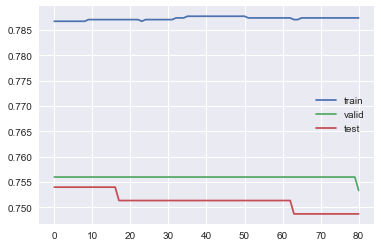

CRDataset
Train precision 0.7874172185430464
Valid precision 0.7557029177718833
Test precision 0.7486772486772486
[('aux', 1.0000000000105689), ('handheld', 1.000000038272115), ('booted', 1.0000000047932236), ('shipping', 1.0000002982700895), ('words', 1.0000000033343648), ('accessible', 1.0000000034376924), ('faster', 0.9999943620788654), ('suggested', 1.0000004540143757), ('04', 0.9999999994260594), ('database', 1.000252741889907)]
CRDataset tfor 0.1 200 CRDataset_tfor_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-28:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



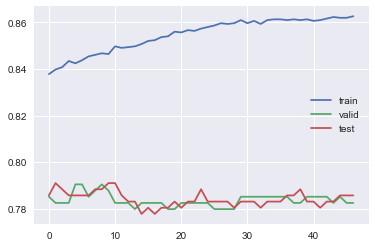


CRDataset
Train precision 0.8615231788079469
Valid precision 0.7838196286472149
Test precision 0.7843915343915343
[('aux', 1.0000098970190037), ('handheld', 1.0010353226618243), ('booted', 1.0008368934233505), ('shipping', 0.9956392337521895), ('words', 0.9982986719434271), ('accessible', 1.000827522381652), ('faster', 1.0546981676427634), ('suggested', 1.0011835401303055), ('04', 1.0001369105746745), ('database', 1.0490833967202997)]
CRDataset tfor 0.1 300 CRDataset_tfor_0.1_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

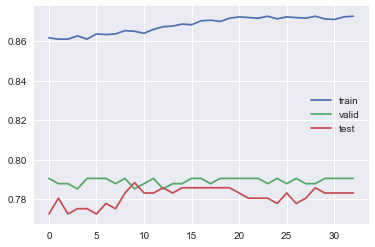

CRDataset
Train precision 0.8718543046357615
Valid precision 0.7893899204244033
Test precision 0.7817460317460319
[('aux', 1.0000310617049382), ('handheld', 1.0017848751177425), ('booted', 1.0006752022349752), ('shipping', 1.008972359923848), ('words', 0.9999952609692287), ('accessible', 1.0001621600067037), ('faster', 1.0422462854695962), ('suggested', 1.0012381797595802), ('04', 1.00002882613303), ('database', 1.0321163219540914)]
CRDataset tfor 0.1 400 CRDataset_tfor_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



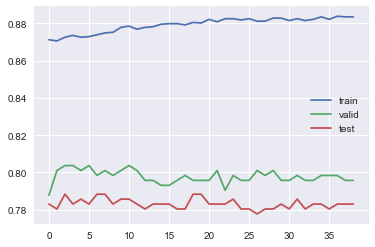


CRDataset
Train precision 0.8826490066225166
Valid precision 0.7968169761273209
Test precision 0.7825396825396826
[('aux', 1.0000630560405241), ('handheld', 1.0032685916540998), ('booted', 1.0007129667325236), ('shipping', 1.0269311180010405), ('words', 0.9997277632708694), ('accessible', 0.999000551706886), ('faster', 1.1497746345007889), ('suggested', 1.0013388592500936), ('04', 0.9999382822494445), ('database', 1.083946078263919)]
CRDataset tfor 0.01 200 CRDataset_tfor_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

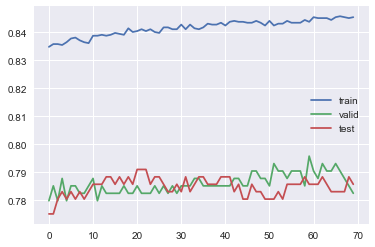

CRDataset
Train precision 0.8451655629139072
Valid precision 0.7891246684350133
Test precision 0.7851851851851852
[('aux', 0.9999995060516456), ('handheld', 1.0002529345055635), ('booted', 1.0002368678915021), ('shipping', 0.998717695740448), ('words', 0.9998681020834973), ('accessible', 1.0001318912183388), ('faster', 1.0099044955789764), ('suggested', 1.0002510495076395), ('04', 1.0000357595795337), ('database', 1.0083570592121054)]
CRDataset tfor 0.01 300 CRDataset_tfor_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-30:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



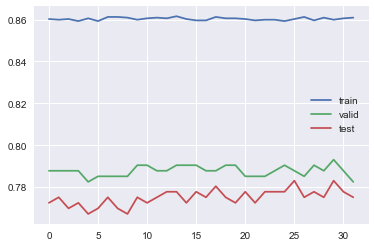


CRDataset
Train precision 0.8602649006622517
Valid precision 0.7877984084880636
Test precision 0.7780423280423281
[('aux', 1.0000020093450037), ('handheld', 1.0002658538774427), ('booted', 1.0001314397785799), ('shipping', 1.0013640292574528), ('words', 1.000030408259156), ('accessible', 0.9999922928743714), ('faster', 1.0039774582906098), ('suggested', 1.000220333103161), ('04', 1.0000083760014666), ('database', 1.004698321486786)]
CRDataset tfor 0.01 400 CRDataset_tfor_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

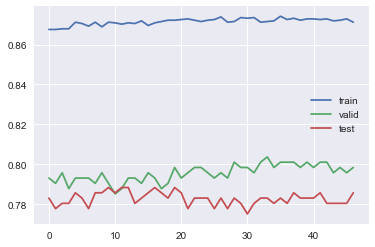

CRDataset
Train precision 0.8724503311258278
Valid precision 0.7989389920424403
Test precision 0.7828042328042328
[('aux', 1.0000065759172656), ('handheld', 1.0006407587881705), ('booted', 1.0001851862049687), ('shipping', 1.0042709725385253), ('words', 1.0000307345877093), ('accessible', 0.9998436383110291), ('faster', 1.0225526608085573), ('suggested', 1.0003131365459295), ('04', 1.0000026135746494), ('database', 1.01138265623233)]
CRDataset tfor 0.001 200 CRDataset_tfor_0.001_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-31:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



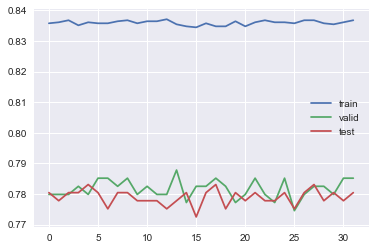


CRDataset
Train precision 0.836225165562914
Valid precision 0.7811671087533156
Test precision 0.7791005291005291
[('aux', 0.9999999148764028), ('handheld', 1.000012476283262), ('booted', 1.0000135964737573), ('shipping', 1.000038338372665), ('words', 0.9999952123156596), ('accessible', 1.000005644141204), ('faster', 1.0004944618271618), ('suggested', 1.0000093432402941), ('04', 1.00000210815315), ('database', 1.0003567206808)]
CRDataset tfor 0.001 300 CRDataset_tfor_0.001_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

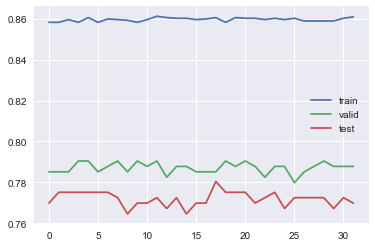

CRDataset
Train precision 0.8596688741721854
Valid precision 0.786472148541114
Test precision 0.7714285714285715
[('aux', 1.000000139198093), ('handheld', 1.0000268996352983), ('booted', 1.0000151530575248), ('shipping', 1.0001699978735685), ('words', 1.0000047768025517), ('accessible', 0.9999986369000613), ('faster', 1.0003111063669183), ('suggested', 1.0000232174613322), ('04', 1.0000011923646923), ('database', 1.0004668936034877)]
CRDataset tfor 0.001 400 CRDataset_tfor_0.001_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-32:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



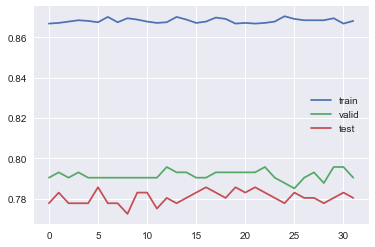


CRDataset
Train precision 0.8685099337748344
Valid precision 0.7912466843501326
Test precision 0.7806878306878307
[('aux', 1.0000003479842385), ('handheld', 1.0000478439566935), ('booted', 1.000016102128402), ('shipping', 1.0003258734549874), ('words', 1.0000041146563448), ('accessible', 0.9999892766778453), ('faster', 1.001574770647649), ('suggested', 1.0000237018325693), ('04', 1.0000007642327555), ('database', 1.0007982409520442)]
CRDataset tfrf 0.1 200 CRDataset_tfrf_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

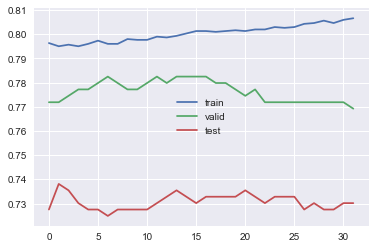

CRDataset
Train precision 0.8042384105960265
Valid precision 0.7716180371352784
Test precision 0.7301587301587302
[('aux', 0.9994806091969544), ('handheld', 1.0003043761446346), ('booted', 1.0004378368541915), ('shipping', 0.9800232806517395), ('words', 1.0000177134958714), ('accessible', 1.0005815348927443), ('faster', 1.0112910151781929), ('suggested', 1.000547541484956), ('04', 0.9999789359179183), ('database', 1.001412687767397)]
CRDataset tfrf 0.1 300 CRDataset_tfrf_0.1_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-33:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



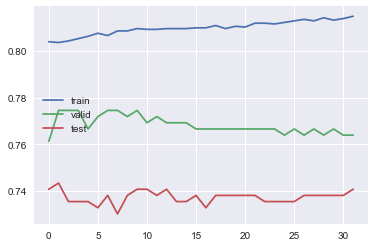


CRDataset
Train precision 0.8131456953642383
Valid precision 0.7652519893899203
Test precision 0.7373015873015872
[('aux', 0.9992442708087358), ('handheld', 1.0004421093735945), ('booted', 1.0005379619836834), ('shipping', 1.0324170142767093), ('words', 1.0000138969086727), ('accessible', 1.0011971013684822), ('faster', 1.0253902817381748), ('suggested', 1.0005053014474798), ('04', 0.9999772320603871), ('database', 1.002480215403829)]
CRDataset tfrf 0.1 400 CRDataset_tfrf_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

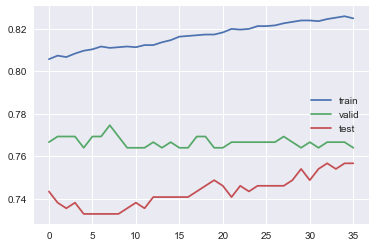

CRDataset
Train precision 0.8238741721854304
Valid precision 0.7660477453580903
Test precision 0.7521164021164021
[('aux', 0.9979251896637227), ('handheld', 1.000966622421638), ('booted', 1.0002586945124206), ('shipping', 1.0496538980742172), ('words', 0.9998678858249997), ('accessible', 1.0010566361382227), ('faster', 1.032370939610635), ('suggested', 1.000384686231156), ('04', 0.9998801934041357), ('database', 1.0026953362097242)]
CRDataset tfrf 0.01 200 CRDataset_tfrf_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-34:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



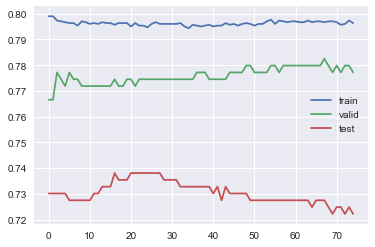


CRDataset
Train precision 0.7966887417218544
Valid precision 0.7793103448275862
Test precision 0.7248677248677249
[('aux', 0.9998575183494985), ('handheld', 1.0000274822555821), ('booted', 1.0001328026344216), ('shipping', 0.9936346654472716), ('words', 1.000003302912435), ('accessible', 1.0001381466896775), ('faster', 1.0028183389580276), ('suggested', 1.0001402795726644), ('04', 0.9999945065504147), ('database', 1.0002565999122248)]
CRDataset tfrf 0.01 300 CRDataset_tfrf_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

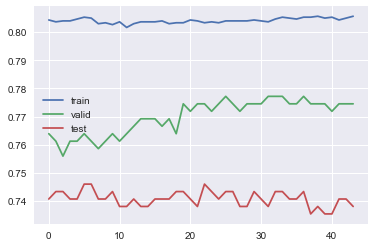

CRDataset
Train precision 0.8050993377483444
Valid precision 0.7745358090185677
Test precision 0.7388888888888888
[('aux', 0.9998707890480245), ('handheld', 1.0000855486459754), ('booted', 1.0000982860594265), ('shipping', 1.0036428802920652), ('words', 1.0000061464513055), ('accessible', 1.0000854859290518), ('faster', 1.003924419438304), ('suggested', 1.0000925995800494), ('04', 0.9999974640550343), ('database', 1.0001503664757188)]
CRDataset tfrf 0.01 400 CRDataset_tfrf_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-35:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



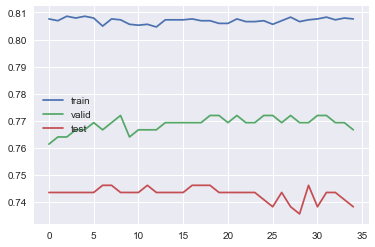


CRDataset
Train precision 0.8073509933774835
Valid precision 0.770026525198939
Test precision 0.7404761904761904
[('aux', 0.9997118667393337), ('handheld', 1.0001185547333902), ('booted', 1.0000615773094426), ('shipping', 1.0032746673529014), ('words', 1.0000062408321584), ('accessible', 1.0000450529768257), ('faster', 1.004770833003796), ('suggested', 1.000055664053254), ('04', 0.9999822524666476), ('database', 1.0003094409116293)]
CRDataset tfrf 0.001 200 CRDataset_tfrf_0.001_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

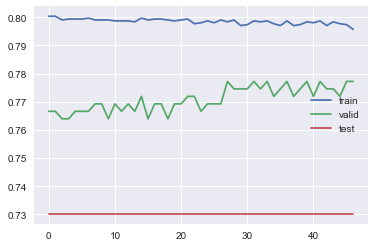

CRDataset
Train precision 0.7975496688741721
Valid precision 0.7748010610079575
Test precision 0.7301587301587302
[('aux', 0.999993639885219), ('handheld', 1.0000018195826499), ('booted', 1.0000089015711187), ('shipping', 0.99945176777146), ('words', 1.0000007105658812), ('accessible', 1.0000108547789313), ('faster', 1.000173705513545), ('suggested', 1.0000085529211362), ('04', 0.999999438427049), ('database', 1.0000100435429342)]
CRDataset tfrf 0.001 300 CRDataset_tfrf_0.001_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-36:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



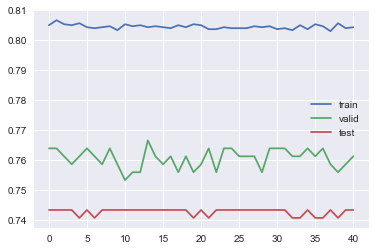


CRDataset
Train precision 0.804271523178808
Valid precision 0.7610079575596818
Test precision 0.7420634920634921
[('aux', 0.999987928489057), ('handheld', 1.000008176592425), ('booted', 1.0000086079019188), ('shipping', 1.0002730281166492), ('words', 1.0000016317266651), ('accessible', 1.0000052936865849), ('faster', 1.0003786729908346), ('suggested', 1.0000081856154825), ('04', 0.9999997146695816), ('database', 1.0000129866380922)]
CRDataset tfrf 0.001 400 CRDataset_tfrf_0.001_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

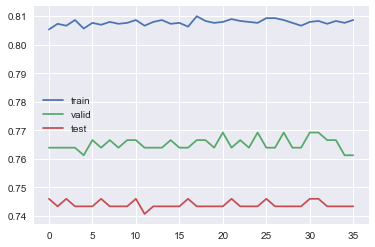

CRDataset
Train precision 0.8080132450331124
Valid precision 0.7655172413793103
Test precision 0.743915343915344
[('aux', 0.9999692688872801), ('handheld', 1.0000124033286206), ('booted', 1.0000063800711023), ('shipping', 1.0002905440326926), ('words', 1.0000023936698827), ('accessible', 1.0000052648063245), ('faster', 1.0005256200359534), ('suggested', 1.0000054370280453), ('04', 0.9999977155043626), ('database', 1.0000318678915865)]
MRDataset None 0.1 200 MRDataset_None_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-37:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



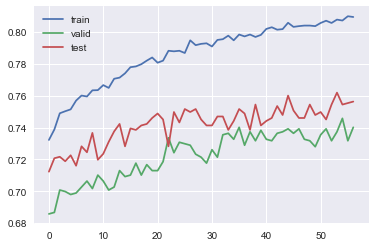

MRDataset
Train precision 0.8064954859889788
Valid precision 0.7353658536585365
Test precision 0.7525773195876289
[('accessible', 0.9696280055780371), ('lodging', 1.0003052854462386), ('movements', 1.0643917357579544), ('disorienting', 1.0084266764788308), ('dynamism', 1.0004630627761333), ('artistic', 0.9972017788398448), ('retains', 0.9922805099929014), ('worst', 1.16011616202526), ('sees', 1.0419731187508703), ('see', 1.1539610550454107)]
MRDataset None 0.1 400 MRDataset_None_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-38:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



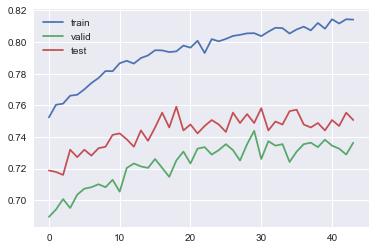


MRDataset
Train precision 0.8105522335561026
Valid precision 0.7331144465290806
Test precision 0.7504217432052485
[('accessible', 0.9982603937307187), ('lodging', 0.9993130354616554), ('movements', 1.0584040528704388), ('disorienting', 1.0061586838257608), ('dynamism', 1.000480247792997), ('artistic', 0.9358395177127696), ('retains', 0.9965314724567933), ('worst', 1.174028066134538), ('sees', 1.0276897180059614), ('see', 1.0154582611244636)]
MRDataset None 0.01 200 MRDataset_None_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

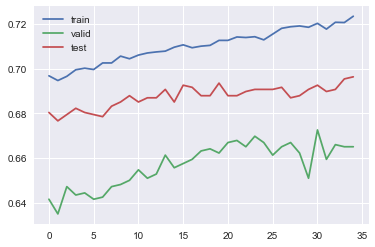

MRDataset
Train precision 0.7192402391839605
Valid precision 0.6635084427767355
Test precision 0.6912839737582006
[('accessible', 1.0003738274102736), ('lodging', 0.999987480970694), ('movements', 1.002597261589826), ('disorienting', 1.0006766224651171), ('dynamism', 1.0000035471333006), ('artistic', 1.001453282606376), ('retains', 0.9999620346987423), ('worst', 1.2615875566636061), ('sees', 1.0012463379678345), ('see', 1.0001249219417383)]
MRDataset None 0.01 300 MRDataset_None_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-39:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



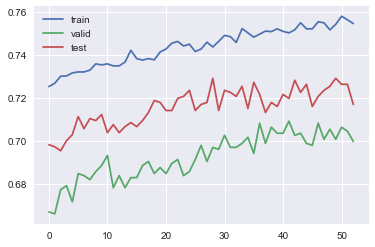


MRDataset
Train precision 0.75444952514949
Valid precision 0.702626641651032
Test precision 0.723336457357076
[('accessible', 1.0003296319026986), ('lodging', 0.9999840962895833), ('movements', 1.0045833723507092), ('disorienting', 1.0014272461570635), ('dynamism', 0.9999539263563018), ('artistic', 1.001140375983343), ('retains', 0.9996261491889601), ('worst', 1.3137711642359167), ('sees', 1.0026898110030253), ('see', 1.022182923162798)]
MRDataset None 0.01 400 MRDataset_None_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

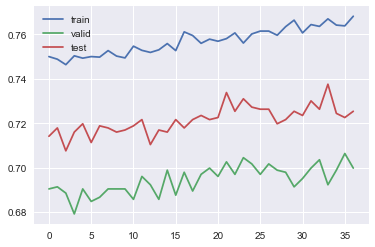

MRDataset
Train precision 0.7641693047250556
Valid precision 0.698405253283302
Test precision 0.7256794751640113
[('accessible', 1.0018286282267965), ('lodging', 0.9999899273996465), ('movements', 1.00478191138329), ('disorienting', 1.0009792816161411), ('dynamism', 1.00000242284), ('artistic', 0.9983637944465116), ('retains', 1.0000097407576356), ('worst', 1.17928893478), ('sees', 1.0008865270576384), ('see', 1.0062132707929345)]
MRDataset None 0.001 200 MRDataset_None_0.001_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-40:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



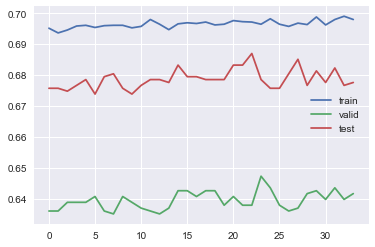


MRDataset
Train precision 0.697350216907023
Valid precision 0.6403377110694184
Test precision 0.678912839737582
[('accessible', 1.0000471728734528), ('lodging', 0.9999986537267127), ('movements', 1.000231365222166), ('disorienting', 0.9999944052022094), ('dynamism', 1.0000025984049927), ('artistic', 1.0001363607551212), ('retains', 0.9999978135970936), ('worst', 1.0198926921853446), ('sees', 1.0001013426815781), ('see', 0.9982225407135208)]
MRDataset None 0.001 300 MRDataset_None_0.001_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

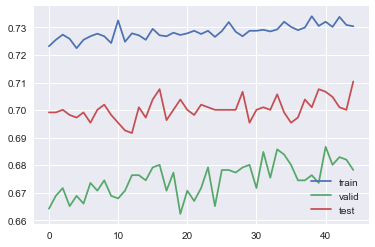

MRDataset
Train precision 0.7311408136944542
Valid precision 0.6788930581613508
Test precision 0.7028116213683224
[('accessible', 1.0000277171980876), ('lodging', 1.0000033228220742), ('movements', 1.0004541562053002), ('disorienting', 1.0001520920010067), ('dynamism', 0.9999957028704092), ('artistic', 1.0000963893990398), ('retains', 0.999972058553361), ('worst', 1.0387881854071503), ('sees', 1.0002928412335148), ('see', 1.0030818382661961)]
MRDataset None 0.001 400 MRDataset_None_0.001_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-41:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



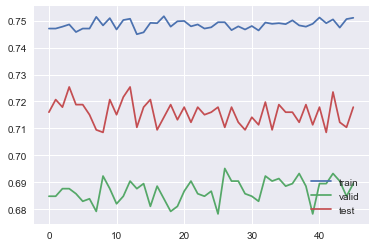


MRDataset
Train precision 0.749501700082073
Valid precision 0.6886491557223264
Test precision 0.7149015932521088
[('accessible', 1.0002318312960738), ('lodging', 0.9999993524520482), ('movements', 1.0005520070079688), ('disorienting', 1.0001241502317502), ('dynamism', 1.0000002958018015), ('artistic', 0.9999425141508312), ('retains', 1.0000045099976647), ('worst', 1.0475134201981684), ('sees', 1.0001146570906867), ('see', 1.0009147862152719)]
MRDataset tfidf 0.1 200 MRDataset_tfidf_0.1_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

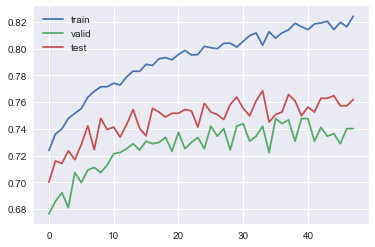

MRDataset
Train precision 0.8182319146441552
Valid precision 0.7378048780487804
Test precision 0.7586691658856607
[('accessible', 0.8812042688278714), ('lodging', 0.9957041749134835), ('movements', 1.0688226626026454), ('disorienting', 1.014275311286774), ('dynamism', 1.000706429972364), ('artistic', 0.9623410137467048), ('retains', 0.9915109117460446), ('worst', 1.1243626826585866), ('sees', 1.0366742718854205), ('see', 1.099947047699582)]
MRDataset tfidf 0.1 300 MRDataset_tfidf_0.1_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-42:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



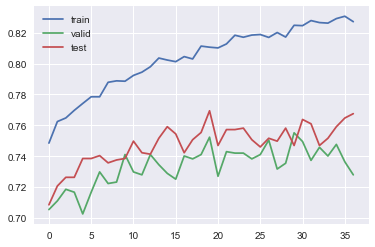


MRDataset
Train precision 0.8254543322781099
Valid precision 0.7407129455909943
Test precision 0.7569821930646673
[('accessible', 0.9630980410537924), ('lodging', 0.9882326948566592), ('movements', 1.079482826672858), ('disorienting', 1.0088333575337065), ('dynamism', 1.0011781659023986), ('artistic', 0.9342524167585765), ('retains', 0.989211725852147), ('worst', 0.9391597065866787), ('sees', 1.0350473530917756), ('see', 0.9550133964657168)]
MRDataset tfidf 0.1 400 MRDataset_tfidf_0.1_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

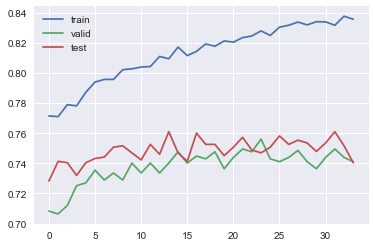

MRDataset
Train precision 0.8326298510962598
Valid precision 0.7432457786116322
Test precision 0.7524835988753515
[('accessible', 0.9826623716079042), ('lodging', 0.9841688120884663), ('movements', 1.0752417492969166), ('disorienting', 1.006752390708814), ('dynamism', 1.0023828257786642), ('artistic', 0.8970717729184747), ('retains', 0.9914663506583922), ('worst', 0.9037208699716798), ('sees', 1.0155594380789321), ('see', 0.9475956642217496)]
MRDataset tfidf 0.01 200 MRDataset_tfidf_0.01_200


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-43:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



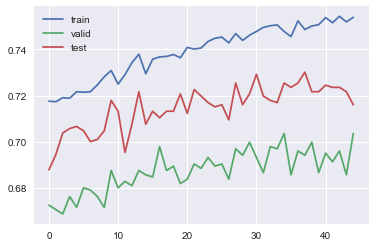


MRDataset
Train precision 0.7511783327470981
Valid precision 0.6934333958724201
Test precision 0.7231490159325211
[('accessible', 0.9930214085681589), ('lodging', 0.9995360146618004), ('movements', 1.0074041933113251), ('disorienting', 1.002025753677039), ('dynamism', 1.0000085535613497), ('artistic', 1.002937162962942), ('retains', 0.9998986813383325), ('worst', 1.1898569262424041), ('sees', 1.0011689713053917), ('see', 1.0092945046004511)]
MRDataset tfidf 0.01 300 MRDataset_tfidf_0.01_300


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

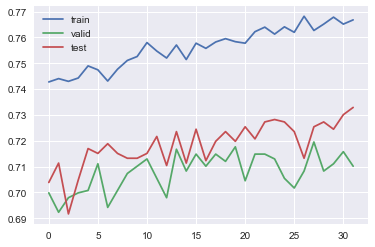

MRDataset
Train precision 0.7647203658107633
Valid precision 0.7107879924953096
Test precision 0.7259606373008435
[('accessible', 0.9989391745068693), ('lodging', 0.9998966764098937), ('movements', 1.005563287681831), ('disorienting', 1.001322699196209), ('dynamism', 0.9999698122613915), ('artistic', 1.00193614539012), ('retains', 0.9996120769055621), ('worst', 1.1301560911332325), ('sees', 1.0010521024929069), ('see', 0.9998497899910275)]
MRDataset tfidf 0.01 400 MRDataset_tfidf_0.01_400


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

Exception in thread Thread-44:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [ ]:
start = True
start_on = 'CRDataset_tfig_0.001_400'
dump_results = False

for dataset in datasets.ALL_DATASETS+ datasets.TREC_DATASETS:
    for scheme in SimpleModel.SCHEMES:
        for alpha in [0.1, 0.01, 0.001]:
            for dims in [200, 300, 400]:
                tag = '{}_{}_{}_{}'.format(dataset.name(), scheme, alpha, dims)
                if not start:
                    start = (tag == start_on)
                    continue
                print(dataset.name(), scheme, alpha, dims, tag)
                model = SimpleModel(classify.SkClassifier(), use_svd=True, weights=scheme, svd_dim=dims)
                test_simple_model_with_gradient(
                    model, dataset, alpha=alpha, dims=dims, tag=scheme, 
                    gradient_iters=None, results=results, dump=dump, with_models=False)
                print(list(model.internal_w.items())[:10])
                results_file = 'dumps/batch_results_{}.pickle'.format(tag)
                dumps_file = 'dumps/batch_dump_{}.pickle'.format(tag)
                if dump_results:
                    pickle.dump(results, open(results_file, 'bw'))
                    pickle.dump(dump, open(dumps_file, 'bw'))

                

In [ ]:
pd.DataFrame(results)